In [1]:
import os
import sys
import time
import copy

import numpy as np
import math
import random
import matplotlib.pyplot as plt

import functools
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import pickle

import datasets, models
import importlib
importlib.reload(models)
import init, measures

In [63]:
from dataclasses import dataclass
@dataclass
class config:

    device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

    dataset = 'rhm'
    mode = 'masked'
    num_features = 16
    num_classes = 16
    num_synonyms = 4
    tuple_size = 2
    num_layers = 4
    seed_rules = 2362346
    num_tokens = 16 # context length, tuple_size**num_layers for the full input

    train_size = 2**22
    batch_size = 128
    accumulation = 1
    test_size = 32768
    seed_sample = 34534
    replacement = False

    input_format = 'onehot'
    whitening = 1

    model = 'hcnn'
    depth = 4
    width = 256
    filter_size = 2
    # model = 'transformer_mla'
    # depth = 3
    # num_heads = 16
    # embedding_dim = 256
    bias = False
    seed_model = 359

    optim = 'sgd'
    lr = 1.0
    momentum = 0.0
    scheduler = None
    scheduler_time = 1024
    max_epochs = 1

    print_freq = 1024
    save_freq = 2
    loss_threshold = 1e-3

    outname = 'test'

config.rules = True
config.bonus = dict.fromkeys(['noise', 'synonyms', 'generate', 'size'])
config.bonus['size'] = config.test_size
config.check_rules = False

config.zipf = None
config.layer = config.num_layers

config.num_data = config.num_classes*config.num_synonyms**((config.tuple_size**config.num_layers-1)//(config.tuple_size-1))
config.input_size = config.tuple_size**config.num_layers
config.num_batches = config.train_size//config.batch_size
config.max_iters = config.max_epochs*config.num_batches

scales = []
for i in range(config.num_layers):
    scales.append(config.num_classes*config.num_synonyms**(2*i+1)/(1.-config.num_synonyms/(config.num_features**config.tuple_size)))
print(config.num_data, config.num_classes*config.num_synonyms**(config.num_layers), scales)

print(config.device)

17179869184 4096 [65.01587301587301, 1040.2539682539682, 16644.06349206349, 266305.01587301586]
cuda


In [64]:
train_loader, test_loader = init.init_data(config)

print(config.rules.keys())

if config.bonus:

    print(config.bonus['features'].size())

    if 'synonyms' in config.bonus:
        for k in config.bonus['synonyms']:
            print(k, config.bonus['features'][0].argmax(dim=0)+1)
            print(k, config.bonus['synonyms'][k][0].argmax(dim=0)+1)
    if 'noise' in config.bonus:
        for k in config.bonus['noise']:
            print(k, config.bonus['features'][0].argmax(dim=0)+1)
            print(k, config.bonus['noise'][k][0].argmax(dim=0)+1)

dict_keys([0, 1, 2, 3])
torch.Size([32768, 16, 16])
4 tensor([ 2, 16,  9, 14,  4, 15,  6,  7, 12,  4,  4, 15,  5,  5,  8,  1])
4 tensor([ 2, 16,  9, 14,  4, 15,  6,  7, 12,  4,  4, 15,  5,  5,  8,  1],
       device='cuda:0')
3 tensor([ 2, 16,  9, 14,  4, 15,  6,  7, 12,  4,  4, 15,  5,  5,  8,  1])
3 tensor([11, 13,  3, 10,  1,  7,  9, 14, 12,  4,  4, 15,  5,  5,  8,  1],
       device='cuda:0')
2 tensor([ 2, 16,  9, 14,  4, 15,  6,  7, 12,  4,  4, 15,  5,  5,  8,  1])
2 tensor([ 2, 16,  9, 14,  4, 15,  6,  7, 12,  4,  4, 15,  5,  5,  8,  1],
       device='cuda:0')
1 tensor([ 2, 16,  9, 14,  4, 15,  6,  7, 12,  4,  4, 15,  5,  5,  8,  1])
1 tensor([ 2, 16,  9, 14,  4, 15,  6,  7, 12,  4,  4, 15,  5,  5,  8,  1],
       device='cuda:0')
4 tensor([ 2, 16,  9, 14,  4, 15,  6,  7, 12,  4,  4, 15,  5,  5,  8,  1])
4 tensor([15, 11, 11,  8,  3, 11, 12,  5,  9,  9, 15, 13,  5,  5,  8,  1],
       device='cuda:0')
3 tensor([ 2, 16,  9, 14,  4, 15,  6,  7, 12,  4,  4, 15,  5,  5,  8,  1])
3 t

In [65]:
model = init.init_model(config)
model0 = copy.deepcopy( model)
param_count = sum([p.numel() for p in model.parameters()])
print(param_count)

405504


In [66]:
criterion, optimizer, scheduler = init.init_training( model, config)

In [67]:
%%time
dynamics, best = init.init_output(model, criterion, train_loader, test_loader, config)
print(dynamics[0])

if config.bonus:
    if 'synonyms' in config.bonus:
        for l in range(config.depth+1):
            for k in dynamics[0]['synonyms'][l].keys():
                print(f'depth {l}, level {k}, sensitivity: ', dynamics[0]['synonyms'][l][k].mean().item())
    if 'noise' in config.bonus:
        for l in range(config.depth+1):
            for k in dynamics[0]['noise'][l].keys():
                print(f'depth {l}, level {k}, sensitivity: ', dynamics[0]['noise'][l][k].mean().item())

{'t': 0, 'testloss': 2.772436261177063, 'testacc': 0.064971923828125, 'synonyms': {0: {4: tensor([0.3530, 0.3500, 0.3508, 0.3411, 0.3524, 0.3477, 0.3204, 0.3155],
       device='cuda:0'), 3: tensor([0.3136, 0.3156, 0.3199, 0.3406, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0'), 2: tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.2851, 0.2683, 1.0000, 1.0000],
       device='cuda:0'), 1: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.2348, 1.0000],
       device='cuda:0')}, 1: {4: tensor([0.3486, 0.3431, 0.3459, 0.3169], device='cuda:0'), 3: tensor([0.3121, 0.3260, 1.0000, 1.0000], device='cuda:0'), 2: tensor([1.0000, 1.0000, 0.2760, 1.0000], device='cuda:0'), 1: tensor([1.0000, 1.0000, 1.0000, 0.4402], device='cuda:0')}, 2: {4: tensor([0.3379, 0.3247], device='cuda:0'), 3: tensor([0.3076, 1.0000], device='cuda:0'), 2: tensor([1.0000, 0.5195], device='cuda:0'), 1: tensor([1.0000, 0.7018], device='cuda:0')}, 3: {4: tensor([0.3198], device='cuda:0'), 3: tensor([0.5691], devi

In [68]:
# config.print_freq = 256
# config.save_freq = 2

print_ckpts, save_ckpts = init.init_loglinckpt( config.print_freq, config.max_iters, freq=config.save_freq)
print_ckpt = next(print_ckpts)
save_ckpt = next(save_ckpts)

step = 0

## TRAINING

In [ ]:
for epoch in range(config.max_epochs):

    model.train()
    optimizer.zero_grad()
    running_loss = 0.

    for batch_idx, (inputs, targets) in enumerate(train_loader):

        outputs = model(inputs.to(config.device))
        loss = criterion(outputs, targets.to(config.device))
        running_loss += loss.item()
        loss /= config.accumulation
        loss.backward()

        if ((batch_idx+1)%config.accumulation==0):
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            step += 1

            if step==print_ckpt:

                test_loss, test_acc = measures.test(model, test_loader, config.device)

                if test_loss<best['loss']: # update best model if loss is smaller
                    best['step'] = step
                    best['loss'] = test_loss
                    best['model'] = copy.deepcopy( model.state_dict())

                print('step : ',step, '\t train loss: {:06.4f}'.format(running_loss/(batch_idx+1)), ',test loss: {:06.4f}'.format(test_loss))
                print_ckpt = next(print_ckpts)

                if step>=save_ckpt:

                    print(f'Checkpoint at step {step}, saving data ...')

                    if config.max_epochs==1:
                        save_dict = {'t': step, 'testloss': test_loss, 'testacc': test_acc}
                    else:
                        train_loss, train_acc = measures.test(model, train_loader, config.device)
                        save_dict = {'t': step, 'trainloss': train_loss, 'trainacc': train_acc, 'testloss': test_loss, 'testacc': test_acc}

                    if config.bonus:
                        if 'synonyms' in config.bonus:
                            save_dict['synonyms'] = measures.sensitivity( model, config.bonus['features'], config.bonus['synonyms'], config.device)
                        if 'noise' in config.bonus:
                            save_dict['noise'] = measures.sensitivity( model, config.bonus['features'], config.bonus['noise'], config.device)
                    dynamics.append(save_dict)
                    save_ckpt = next(save_ckpts)


    if (running_loss/(batch_idx+1)) <= config.loss_threshold:

        if config.max_epochs==1:
            save_dict = {'t': step, 'testloss': test_loss, 'testacc': test_acc}
        else:
            train_loss, train_acc = measures.test(model, train_loader, config.device)
            save_dict = {'t': step, 'trainloss': train_loss, 'trainacc': train_acc, 'testloss': test_loss, 'testacc': test_acc}

        if config.bonus:
            if 'synonyms' in config.bonus:
                save_dict['synonyms'] = measures.sensitivity( model, config.bonus['features'], config.bonus['synonyms'], config.device)
            if 'noise' in config.bonus:
                save_dict['noise'] = measures.sensitivity( model, config.bonus['features'], config.bonus['noise'], config.device)
        dynamics.append(save_dict)

        break

step :  1 	 train loss: 2.7722 ,test loss: 2.7724
Checkpoint at step 1, saving data ...
step :  2 	 train loss: 2.7725 ,test loss: 2.7724
Checkpoint at step 2, saving data ...
step :  3 	 train loss: 2.7726 ,test loss: 2.7724
Checkpoint at step 3, saving data ...
step :  4 	 train loss: 2.7726 ,test loss: 2.7724
Checkpoint at step 4, saving data ...
step :  6 	 train loss: 2.7725 ,test loss: 2.7723
Checkpoint at step 6, saving data ...
step :  8 	 train loss: 2.7724 ,test loss: 2.7722
Checkpoint at step 8, saving data ...
step :  11 	 train loss: 2.7724 ,test loss: 2.7721
Checkpoint at step 11, saving data ...
step :  16 	 train loss: 2.7723 ,test loss: 2.7718
Checkpoint at step 16, saving data ...
step :  23 	 train loss: 2.7721 ,test loss: 2.7713
Checkpoint at step 23, saving data ...
step :  32 	 train loss: 2.7718 ,test loss: 2.7706
Checkpoint at step 32, saving data ...
step :  45 	 train loss: 2.7714 ,test loss: 2.7693
Checkpoint at step 45, saving data ...
step :  64 	 train los

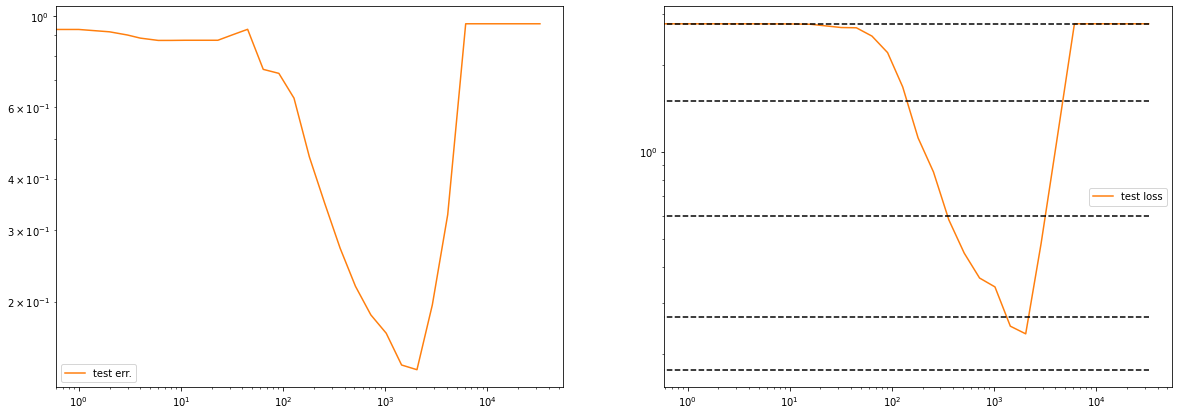

In [62]:
import math

fig, ax = plt.subplots(1, 2, figsize=(20,7))

ax[0].plot([d['t'] for d in dynamics], [1.-d['testacc'] for d in dynamics], f'C1', label='test err.')
if config.max_epochs > 1:
    ax[0].plot([d['t'] for d in dynamics], [1.-d['trainacc'] for d in dynamics], f'C0', label='training err.')

ax[1].plot([d['t'] for d in dynamics], [d['testloss'] for d in dynamics], f'C1', label='test loss')
if config.max_epochs > 1:
    ax[1].plot([d['t'] for d in dynamics], [d['trainloss'] for d in dynamics], f'C0', label='training loss')

L = config.num_layers
v = config.num_features
m = config.num_synonyms
s = config.tuple_size
time = [d['t'] for d in dynamics]

ngram_losses = [math.log(config.num_features), 1.4926, 0.5973, 0.2686, 0.1758] #v=16, m=4
# ngram_losses = [math.log(config.num_features), 2.1266, 1.0060, 0.4300, 0.2491, 0.2025, 0.1911, 0.1883, 0.1876] # v = 32, m = 8

for k in range(L+1):
    # compatible = (v-1)*((v**s-m*v)/(v**s-1-m*(v-1)))*((m*(v-1))/(v**s-1))**k + (v-1)*(m-1)/(v**s-1-m*(v-1))
    # ax[1].plot([t for t in time], [math.log(1+compatible) for t in time], 'k--')
    ax[1].plot([t for t in time], [ngram_losses[k] for t in time], 'k--')


ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
# ax[1].set_ylim(1e-1,1e1)

In [50]:
if config.bonus:
    if 'synonyms' in config.bonus:
        for k in range(config.depth+1):
            for l in range(1,config.num_layers):
                print(f'depth {k}, level {l}, sensitivity: ', dynamics[0]['synonyms'][k][l].mean().item())

depth 0, level 1, sensitivity:  0.903967559337616
depth 0, level 2, sensitivity:  0.8187063932418823
depth 0, level 3, sensitivity:  0.6596078872680664
depth 1, level 1, sensitivity:  0.8593224287033081
depth 1, level 2, sensitivity:  0.8185821771621704
depth 1, level 3, sensitivity:  0.657889723777771
depth 2, level 1, sensitivity:  0.8499535322189331
depth 2, level 2, sensitivity:  0.7592564821243286
depth 2, level 3, sensitivity:  0.6520792245864868
depth 3, level 1, sensitivity:  0.8272688388824463
depth 3, level 2, sensitivity:  0.7258156538009644
depth 3, level 3, sensitivity:  0.5679429173469543
depth 4, level 1, sensitivity:  0.8606945276260376
depth 4, level 2, sensitivity:  0.7605741024017334
depth 4, level 3, sensitivity:  0.6023741960525513


In [ ]:
print(dynamics[0]['noise'].keys())

for key in dynamics[0]['noise'].keys():
    print(f'rep. {key+1}', dynamics[-1]['noise'][key])

dict_keys([0, 1, 2, 3, 4])
dict_keys([4, 3, 2, 1])


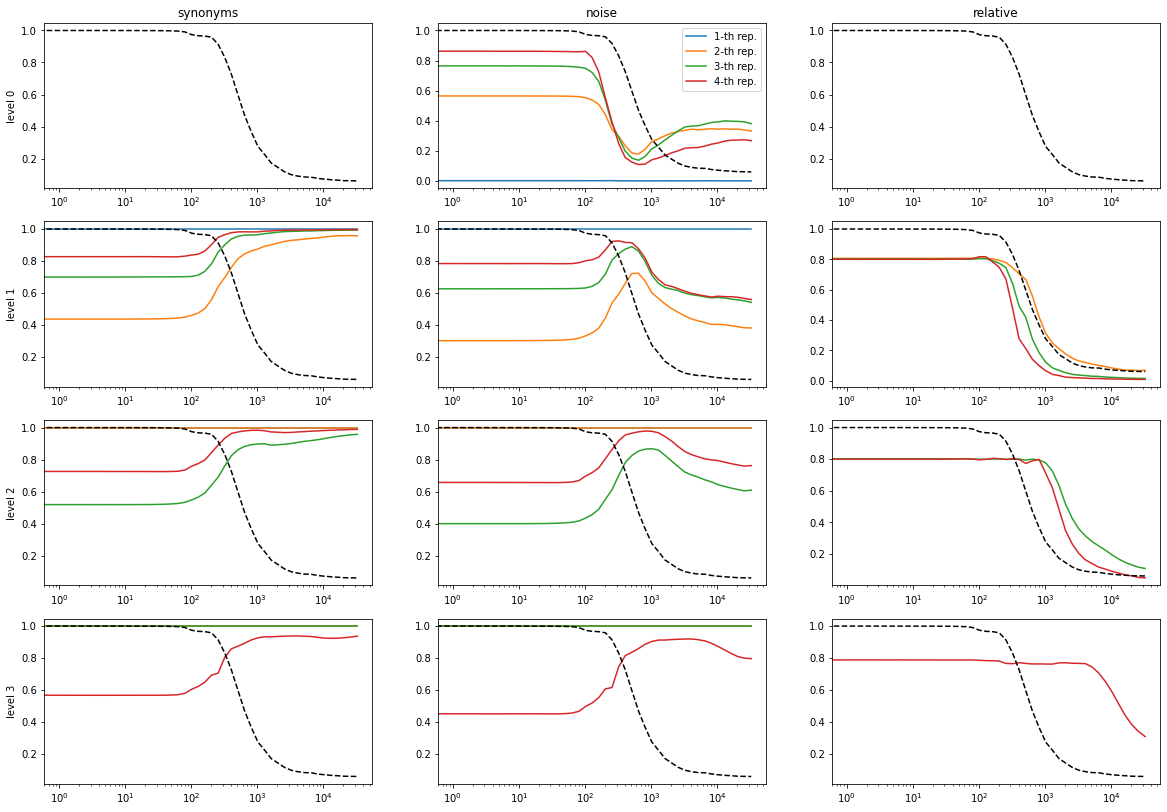

In [51]:
fig, ax = plt.subplots((config.num_layers), 3, figsize=(20,14))


print(dynamics[-1]['synonyms'].keys())
print(dynamics[-1]['synonyms'][3].keys())

ax[0][0].set_title('synonyms')
ax[0][1].set_title('noise')
ax[0][2].set_title('relative')

for k in range(config.depth):

    l = 0
    ax[0][1].plot([d['t'] for d in dynamics], [d['noise'][k][l][-1].to('cpu') for d in dynamics], f'C{k}' , label=f'{k+1}-th rep.')

    ax[l][0].set_ylabel(f'level {l}')
    ax[0][0].set_xscale('log')
    ax[0][1].set_xscale('log')
    ax[0][2].set_xscale('log')


    for l in range(1,config.num_layers):

        ax[l][0].plot([d['t'] for d in dynamics], [d['synonyms'][k][l][-1].to('cpu') for d in dynamics], f'C{k}' , label=f'{k+1}-th rep.')
        ax[l][1].plot([d['t'] for d in dynamics], [d['noise'][k][l][-1].to('cpu') for d in dynamics], f'C{k}' , label=f'{k+1}-th rep.')
        ax[l][2].plot([d['t'] for d in dynamics], [(1.-d['synonyms'][k][l][-1].to('cpu'))/((1.-d['noise'][k][l][-1].to('cpu'))) for d in dynamics], f'C{k}' , label=f'{k+1}-th rep.')

        ax[l][0].set_ylabel(f'level {l}')
        ax[l][0].set_xscale('log')
        ax[l][1].set_xscale('log')
        ax[l][2].set_xscale('log')

init_loss = dynamics[0]['testloss']
for l in range(config.num_layers):

    ax[l][0].plot([d['t'] for d in dynamics], [d['testloss']/init_loss for d in dynamics], f'k--')
    ax[l][1].plot([d['t'] for d in dynamics], [d['testloss']/init_loss for d in dynamics], f'k--')
    ax[l][2].plot([d['t'] for d in dynamics], [d['testloss']/init_loss for d in dynamics], f'k--')

ax[0][1].legend()

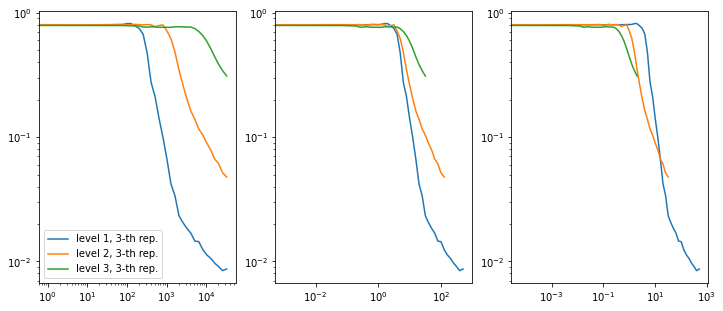

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))

m = config.num_synonyms

l = 1
k = 3
ax[0].plot([d['t'] for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[1].plot([d['t']/(m**(l+2)) for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[2].plot([d['t']/(m**(2*(l+1)-1)) for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')


l = 2
k = 3
ax[0].plot([d['t'] for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[1].plot([d['t']/(m**(l+2)) for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[2].plot([d['t']/(m**(2*(l+1)-1)) for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')

l = 3
k = 3
ax[0].plot([d['t'] for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[1].plot([d['t']/(m**(l+2)) for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[2].plot([d['t']/(m**(2*(l+1)-1)) for d in dynamics], [(1.-d['synonyms'][k][l].to('cpu'))/((1.-d['noise'][k][l].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')

ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[2].set_xscale('log')
ax[2].set_yscale('log')

ax[0].legend()

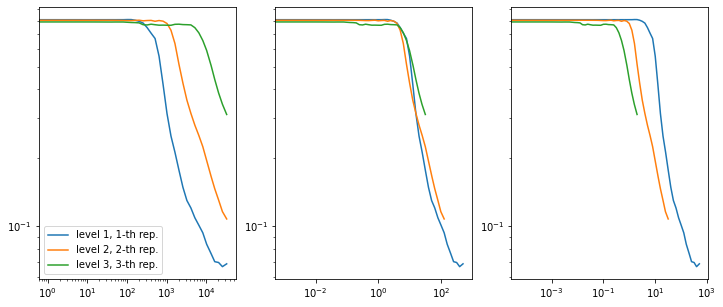

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))

m = config.num_synonyms

l = 1
k = l
ax[0].plot([d['t'] for d in dynamics], [(1.-d['synonyms'][k][l][-1].to('cpu'))/((1.-d['noise'][k][l][-1].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[1].plot([d['t']/(m**(l+2)) for d in dynamics], [(1.-d['synonyms'][k][l][-1].to('cpu'))/((1.-d['noise'][k][l][-1].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[2].plot([d['t']/(m**(2*(l+1)-1)) for d in dynamics], [(1.-d['synonyms'][k][l][-1].to('cpu'))/((1.-d['noise'][k][l][-1].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')


l = 2
k = l
ax[0].plot([d['t'] for d in dynamics], [(1.-d['synonyms'][k][l][-1].to('cpu'))/((1.-d['noise'][k][l][-1].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[1].plot([d['t']/(m**(l+2)) for d in dynamics], [(1.-d['synonyms'][k][l][-1].to('cpu'))/((1.-d['noise'][k][l][-1].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[2].plot([d['t']/(m**(2*(l+1)-1)) for d in dynamics], [(1.-d['synonyms'][k][l][-1].to('cpu'))/((1.-d['noise'][k][l][-1].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')

l = 3
k = l
ax[0].plot([d['t'] for d in dynamics], [(1.-d['synonyms'][k][l][-1].to('cpu'))/((1.-d['noise'][k][l][-1].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[1].plot([d['t']/(m**(l+2)) for d in dynamics], [(1.-d['synonyms'][k][l][-1].to('cpu'))/((1.-d['noise'][k][l][-1].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')
ax[2].plot([d['t']/(m**(2*(l+1)-1)) for d in dynamics], [(1.-d['synonyms'][k][l][-1].to('cpu'))/((1.-d['noise'][k][l][-1].to('cpu'))) for d in dynamics], f'C{l-1}' , label=f'level {l}, {k}-th rep.')


ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[2].set_xscale('log')
ax[2].set_yscale('log')

ax[0].legend()